---
title: "NIST (part 1): Preparing a spectral library for ML"

date: 2022-10-05
date-modified: last-modified

author:

- name: Ralf Gabriels

  orcid: 0000-0002-1679-1711

  affiliations:
    - VIB-UGent Center for Medical Biotechnology, VIB, Belgium
    - Department of Biomolecular Medicine, Ghent University, Belgium

---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ProteomicsML/ProteomicsML/blob/main/tutorials/fragmentation/_nist-1-parsing-spectral-library.ipynb)


## 1 Introduction

### 1.1 Fragmentation peak intensities

In bottom-up proteomics, a peptide fragmentation spectrum (MS2) is the most central
source of information to identify a peptide. In traditional identification workflows,
only the presence and location (x-axis) of peaks in the spectrum are used to identify
the peptide that generated the spectrum. The intensity of these peaks (y-axis) are,
however, seldomly used in a comprehensive manner. At most, traditional approaches
naively assume that higher intensity is always better.

This lack of usage of fragmentation peak intensity patterns can mainly be attributed to
their complexity. While the location of certain peaks (e.g., b- and y-ions) can easily
be calculated from the amino acid masses, fragment peak intensity follow complex, yet
predictable patterns. This makes fragmentation peak intensity values a perfect candidate
for machine learning.

ML-predicted fragmentation peak intensities have proven their value in many
applications, for instance, manual spectrum validation, peptide identification
(re)scoring, and for generating *in silico* predicted spectral libraries for
data-independant acquisition (DIA) identification.


### 1.2 About this tutorial

In this three-part tutorial you will learn the basic steps in developing a machine
learning (ML) predictor for peptide fragmentation intensity prediction, using a NIST
spectral library. The first part handles the preparation and parsing of
training data; the second part handles training a traditional ML model with
XGBoost, similar to MS²PIP [@Gabriels2019], and the third part handles training
a deep learning BiLSTM predictor.

1. [Preparing a spectral library for ML][part1]
2. [Traditional ML: Gradient boosting][part2]
3. [Deep learning: BiLSTM][part3]


[part1]: https://www.proteomicsml.org/tutorials/fragmentation/nist-1-parsing-spectral-library.html
[part2]: https://www.proteomicsml.org/tutorials/fragmentation/nist-2-traditional-ml-gradient-boosting.html
[part3]: https://www.proteomicsml.org/tutorials/fragmentation/nist-3-deep-learning-lstm.html


To avoid an overly complex tutorial, some aspects to intensity prediction are simplified
or not handled. For example, the resulting models will only be able to predict singly
charged b- and y-ions for unmodified peptides.

In [ ]:
# Installing required python packages (versions tested with Python 3.10.11)
! pip install rich numpy pandas pyarrow matplotlib seaborn scikit-learn spectrum_utils --quiet

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


## 2 Finding spectral libraries

Training data for peptide fragmentation spectrum intensity prediction consists of
spectra that were already identified. The most convenient source of such information are
spectral libraries. These are datasets that were compiled from a collection of mass
spectrometry runs and usually consist of a single representative spectrum for each
peptide that was identified. 

Many precompiled spectral libraries are available online. You can also generate your
own from a collection of proteomics experiments, using software such as SpectraST
[@Lam2008].

Spectral libraries can be downloaded, for instance, from NIST, the
[US National Institute of Standards and Technology](https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:cdownload)
. For this part of the practical, we will download the
[2020 Human HCD library of "best" tryptic spectra](https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:lib:humanhcd20160503). For ease-of-use, we will download it in the
text-based NIST MSP format.

The following code cell automatically downloads and extracts the spectral library file.

In [ ]:
import tarfile
import urllib

url = "https://chemdata.nist.gov/download/peptide_library/libraries/human/HCD/2020_05_19/human_hcd_tryp_best.msp.tar.gz"
library_file = "human_hcd_tryp_best.msp"

# Download file
_ = urllib.request.urlretrieve(url, f"{library_file}.tar.gz")

# Extract
with tarfile.open(f"{library_file}.tar.gz") as f:
    f.extractall(".")

Let's explore the MSP spectral library file by printing the first 10 lines of the file:

In [5]:
with open(library_file, "rt") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i > 10:
            break

Name: AAAAAAAAAAAAAAAGAGAGAK/2_0
Comment: Consensus Pep=Tryptic Peptype=<Protein><Peptide><Protein> Mods=0 Fullname=R.AAAAAAAAAAAAAAAGAGAGAK.Q Charge=2 Parent=798.9263 CE=42.09 NCE=29.43 Q-value=0.0000 Nprot=1 Protein="sp|P55011|S12A2_HUMAN(pre=R,post=Q)" Nrep=134/200 Theo_mz_diff=1.2ppm Quality=7/7 MC=0 MCtype=Normal Unassigned_all_20ppm=0.1424 Unassigned_20ppm=0.0416 num_unassigned_peaks_20ppm=44 max_unassigned_ab_20ppm=0.41 top_20_num_unassigned_peaks_20ppm=1/20
Num peaks: 117
110.0712	259243.2	"? 143/200"
115.0864	97764.4	"a2/-1.6ppm 145/200"
116.0704	26069.5	"? 80/200"
120.0806	208924.4	"? 148/200"
129.0657	25535.9	"Int/AG/-1.2ppm,Int/GA/-1.2ppm 86/200"
129.1021	361336.8	"IKD/-1.1ppm,y1-H2O/-1.1ppm 172/200"
130.0860	120990.5	"y1-NH3/-1.9ppm 123/200"
136.0754	401263.5	"? 147/200"
141.1019	54146.8	"? 113/200"


This shows the beginning of the first spectrum in the spectral library. Each spectrum
entry consists of a header with identification data and metadata, and a peak list with
three columns:

 - m/z values
 - intensity values
 - peak annotation info


 As the sequence of the first peptide is `AAAAAAAAAAAAAAAGAGAGAK`, we can assume that
 this library is ordered alphabetically. You can read through the file to verify this
 assumption. When preparing datasets for ML, it is important to be aware of such 
 properties, especially when splitting the data into train, test, and validation sets.

## 3 Parsing the MSP spectral library file

[Pyteomics](https://pyteomics.readthedocs.io/) is a Python package for proteomics that
contains readers for many proteomics-related file formats [@Levitsky2018].
Unfortunately, MSP is not one of the supported formats. So first, we need a custom MSP
reader function.

In [6]:
from rich import print, progress  # Rich is a pretty cool library. Google it ;)
import numpy as np
import pandas as pd

This function iterates over each line in the MSP file. Once it has gathered all
information for a single spectrum, it uses `yield` to return a dictionary. This means
that we can iterate over the function using a `for` loop, and process spectra
one-by-one. 

_If you do not fully understand the function, no problem! This is not the important
part of the tutorial._

In [7]:
def read_msp(filename):
    """Iterate over MSP spectral library file and return spectra as dicts."""
    spectrum = {}
    mz = []
    intensity = []
    annotation = []

    with progress.open(filename, "rt") as f:
        for line in f:
            # `Name: ` is the first line of a new entry in the file
            if line.startswith("Name: "):
                if spectrum:
                    # Finalize and yield previous spectrum
                    spectrum["sequence"] = spectrum["Fullname"].split(".")[1]  # Remove the previous/next amino acids
                    spectrum["mz"] = np.array(mz, dtype="float32")
                    spectrum["intensity"] = np.array(intensity, dtype="float32")
                    spectrum["annotation"] = np.array(annotation, dtype="str")
                    yield spectrum

                    # Define new spectrum
                    spectrum = {}
                    mz = []
                    intensity = []
                    annotation = []

                # Extract everything after `Name: `
                spectrum["Name"] = line.strip()[6:]

            elif line.startswith("Comment: "):
                # Parse all comment items as metadata
                metadata = [i.split("=") for i in line[9:].split(" ")]
                for item in metadata:
                    if len(item) == 2:
                        spectrum[item[0]] = item[1]

            elif line.startswith("Num peaks: "):
                spectrum["Num peaks"] = int(line.strip()[11:])

            elif len(line.split("\t")) == 3:
                # Parse peak list items one-by-one
                line = line.strip().split("\t")
                mz.append(line[0])
                intensity.append(line[1])
                annotation.append(line[2].strip('"'))

    # Final spectrum
    spectrum["sequence"] = spectrum["Fullname"].split(".")[1]  # Remove the previous/next amino acids
    spectrum["mz"] = np.array(mz, dtype="float32")
    spectrum["intensity"] = np.array(intensity, dtype="float32")
    spectrum["annotation"] = np.array(annotation, dtype="str")
    yield spectrum

Let's explore the first spectrum:

In [8]:
# break allows us to only stop after the first spectrum is defined
for spectrum in read_msp("human_hcd_tryp_best.msp"):
    print(spectrum["Name"])
    break

c:\Users\ralfg\git\ProteomicsML\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

AAAAAAAAAAAAAAAGAGAGAK/2_0

We can format the peak list as a Pandas DataFrame:

In [9]:
pd.DataFrame({
    "mz": spectrum["mz"],
    "intensity": spectrum["intensity"],
    "annotation": spectrum["annotation"],
})

,mz,intensity,annotation
0,110.071198,259243.203125,? 143/200
1,115.086403,97764.398438,a2/-1.6ppm 145/200
2,116.070396,26069.500000,? 80/200
3,120.080597,208924.406250,? 148/200
4,129.065704,25535.900391,"Int/AG/-1.2ppm,Int/GA/-1.2ppm 86/200"
...,...,...,...
112,1170.621338,442693.312500,y16/-1.1ppm 180/200
113,1171.624146,173247.703125,y16+i/-1.0ppm 133/200
114,1241.657959,264065.593750,y17/-1.3ppm 170/200
115,1242.660156,112235.101562,y17+i/-1.8ppm 125/200


The right-most column denotes the peak annotation. This tells us which ion generated the
peak, according to the search engine or library generation software. Note that many
peaks (highlighted with a question mark) are not annotated, even though the spectrum was
confidently identified.

Using the Python package [spectrum_utils](https://spectrum-utils.readthedocs.io/)
[@Bittremieux2019] , we can easily visualize the spectrum:


In [10]:
import matplotlib.pyplot as plt

import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup

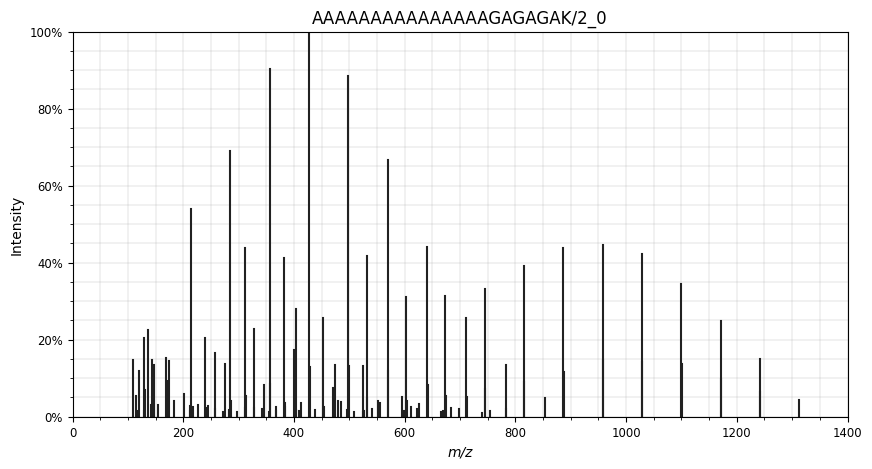

In [11]:
plt.figure(figsize=(10,5))
sup.spectrum(
    sus.MsmsSpectrum(
        identifier=spectrum["Name"],
        precursor_mz=float(spectrum["Parent"]),
        precursor_charge=int(spectrum["Charge"]),
        mz=spectrum["mz"],
        intensity=spectrum["intensity"]
    )
)
plt.title(spectrum["Name"])
plt.show()

## 4 Preparing spectra for training

To use a peptide fragmentation spectrum such as this one as training _target_ for a
machine learning model, it needs some preparation and parsing. Usually this comprises
of the following steps:

1. Normalize the intensities
2. Transform the intensities
3. Annotate the peaks
4. Parse the relevant peak intensities to an format suitable for machine learning

For each of these steps, we will write a function that can be reused later on in
the tutorial.

### 4.1 Normalize the intensities

Depending on the file format, peak intensities can range from 0 to 1, from 0 to 100,
from 0 from 10 000... Machine learning algorithms require the target (and feature)
values to be normalized in a specific range. For fragmentation spectra, there are two
common options: total ion current (TIC) normalization and base peak normalization.
For the former, all intensity values are divided by the total sum of all intensity
values in the spectrum. The sum of all normalized intensities will be `1`. For the
latter, all intensity values are divided by the most intense peak in the spectrum,
resulting in that peak to have normalized intensity  `1`. Here we will implement
TIC-normalization.

In [12]:
def tic_normalize(msp_spectrum):
    tic = np.sum(msp_spectrum["intensity"])
    msp_spectrum["intensity"] = msp_spectrum["intensity"] / tic

In [13]:
# Before normalization
spectrum["intensity"][:10]

array([259243.2,  97764.4,  26069.5, 208924.4,  25535.9, 361336.8,
       120990.5, 401263.5,  54146.8, 259764.2], dtype=float32)

In [14]:
tic_normalize(spectrum)

# After normalization
spectrum["intensity"][:10]

array([0.00882945, 0.00332971, 0.00088789, 0.00711566, 0.00086972,
       0.0123066 , 0.00412076, 0.01366645, 0.00184416, 0.00884719],
      dtype=float32)

### 4.2 Transform the intensities

The distribution of peak intensities shows us that most peptide fragmentation peaks have
a relatively low intensity, while only a few peaks are more intense:

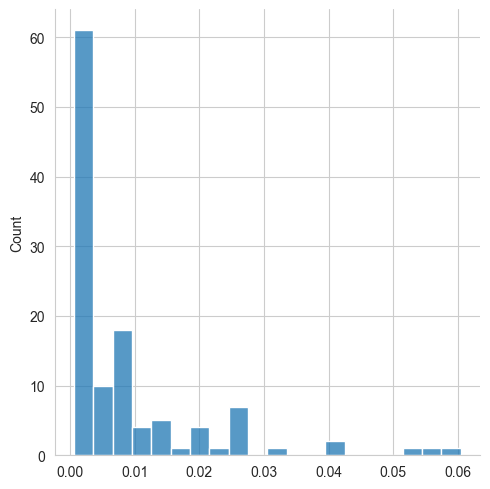

In [15]:
import seaborn as sns
sns.set_style("whitegrid")

# Before transform
sns.displot(spectrum["intensity"], bins=20)
plt.show()

To make the intensities follow a more linear distribution — which is better for machine
learning algorithms — we can transform the intensity values. Two methods are often used:
square root-tranform, and log-transform. While both methods mostly have the same effect,
we will here opt for square root transform, as log-transform results in negative values,
which can be cumbersome to deal with.

In [16]:
def sqrt_transform(msp_spectrum):
    msp_spectrum["intensity"] = np.sqrt(msp_spectrum["intensity"])

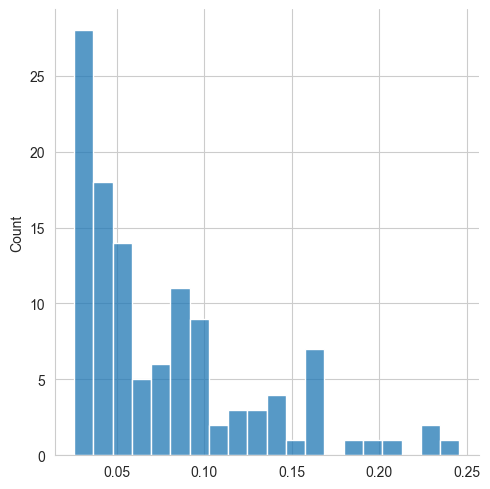

In [17]:
sqrt_transform(spectrum)

# After transform
sns.displot(spectrum["intensity"], bins=20)
plt.show()

### 4.3 Annotate the peaks

With the NIST spectral libraries, this step is pretty easy, as peak annotations are already present. If this would not be the case, we can make use of 
spectrum_utils, which can annotate peaks given the peptide _sequence_ and any _modifications_. See the [spectrum_utils documentation](https://spectrum-utils.readthedocs.io/en/latest/processing.html#peak-annotations) for more info.

Here, we use spectrum_utils to annotate the peaks:

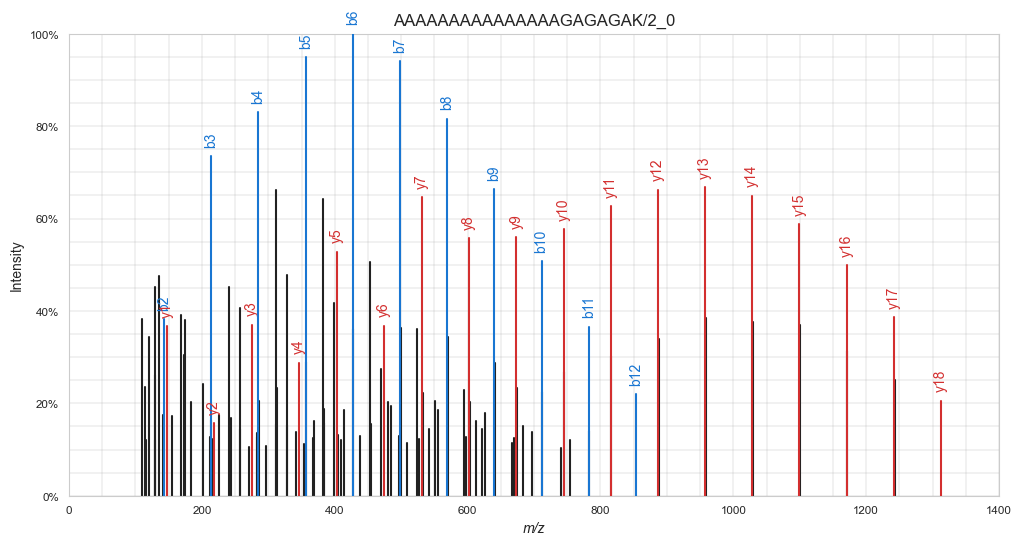

In [18]:
plt.figure(figsize=(12,6))
sup.spectrum(
    sus.MsmsSpectrum(
        identifier=spectrum["Name"],
        precursor_mz=float(spectrum["Parent"]),
        precursor_charge=int(spectrum["Charge"]),
        mz=spectrum["mz"],
        intensity=spectrum["intensity"],
    ).annotate_proforma(spectrum["sequence"], 25, "ppm")
)
plt.title(spectrum["Name"])
plt.show()

### 4.4 Parse the relevant peak intensities to an format suitable for machine learning

Note in the visualization above that spectrum_utils only annotated b- and y-ions, while in the MSP file many other ion types are also annotated. For simplicity's sake, in this tutorial we will train a model to only predict singly charged b- and y-ions. 

Let's filter the spectrum for only those peaks. This can be done with regular
expressions (regex) and numpy. The regex `^(b|y)([0-9]+)\/` only matches peak
annotations for singly charged b- and y-ions. 


:::{.callout-tip}
[regex101.com](https://regex101.com) is a great website for building and testing
regular expressions. You can try out the above mentioned regex at You can investigate it
at [regex101.com/r/bgZ7EG/1](https://regex101.com/r/bgZ7EG/1).
:::

In the `filter_peaks` function below, `numpy.vectorize` is used. What do you think it does and why
do we use it here?

In [19]:
import re

def filter_peaks(msp_spectrum):
    """Filter spectrum peaks to only charge 1 b- and y ions."""
    # Generate the boolean mask
    get_mask = np.vectorize(lambda x: bool(re.match("^(b|y)([0-9]+)\/", x)))
    mask = get_mask(msp_spectrum["annotation"])

    # Apply the mask to each peak array
    msp_spectrum["annotation"] = msp_spectrum["annotation"][mask]
    msp_spectrum["mz"] = msp_spectrum["mz"][mask]
    msp_spectrum["intensity"] = msp_spectrum["intensity"][mask]

filter_peaks(spectrum)

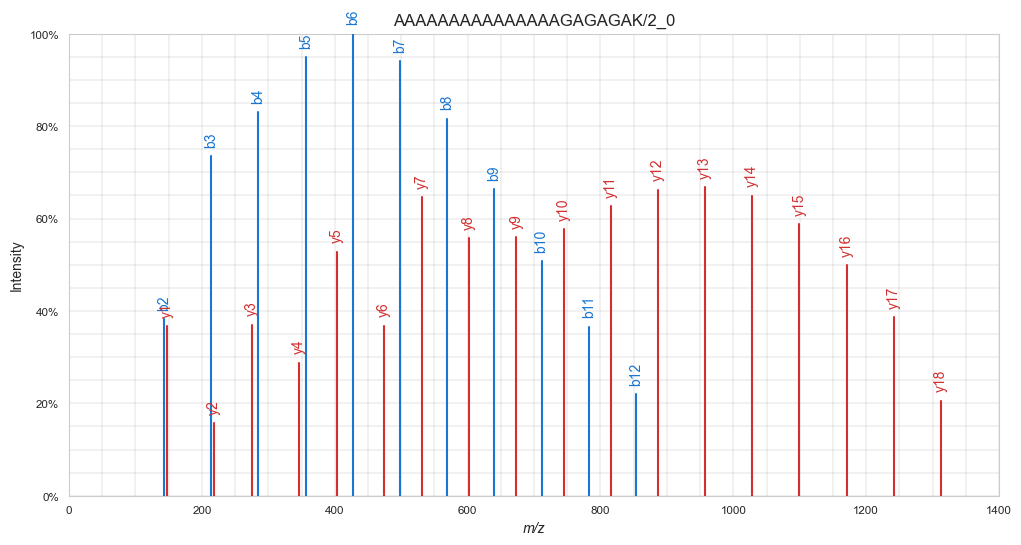

In [20]:
plt.figure(figsize=(12,6))
sup.spectrum(
    sus.MsmsSpectrum(
        identifier=spectrum["Name"],
        precursor_mz=float(spectrum["Parent"]),
        precursor_charge=int(spectrum["Charge"]),
        mz=spectrum["mz"],
        intensity=spectrum["intensity"],
    ).annotate_proforma(spectrum["sequence"], 25, "ppm")
)
plt.title(spectrum["Name"])
plt.show()

Now, the spectrum indeed only contains singly charged b- and y-ions. Note the nice gausian-like distributions of equally-distanced b- and y-ions. This is a feature specific for this peptide spectrum. Can you guess why? Tip: Take a look at the peptide sequence.

Currently, all peaks are listed together in single numpy arrays, sorted by m/z values. For training a machine learning model, we need the intensity values in a more suitable structure. As we are planning to only predict simple singly charged b- and y-ions, we can create two arrays — one for each ion type — with the ions sorted by ion number. For example:

```
b: [b1, b2, b3, b4 ... bN]
y: [y1, y2, y3, y4 ... yN]
```


where N is the total number of possible fragments for that peptide sequence. Quick question: What value will N have for our peptide with sequence `AAAAAAAAAAAAAAAGAGAGAK`?

The following function builds upon the `filter_peaks` function to not only filter the correct ion types, but also order them properly:

In [21]:
def parse_peaks(msp_spectrum, ion_type):
    # Generate vectorized functions
    get_ions = np.vectorize(lambda x: bool(re.match(f"^({ion_type})([0-9]+)\/", x)))
    get_ion_order = np.vectorize(lambda x: re.match(f"^({ion_type})([0-9]+)\/", x)[2])

    # Get mask with requested ion types
    mask = get_ions(msp_spectrum["annotation"])

    # Create empty array with for all possible ions
    n_ions = len(msp_spectrum["sequence"]) - 1
    parsed_intensity = np.zeros(n_ions)

    # Check if any ions of this type are present
    if mask.any():
        # Filter for ion type and sort
        ion_order = get_ion_order(msp_spectrum["annotation"][mask]).astype(int) - 1
        # Add ions to correct positions in new array
        parsed_intensity[ion_order] = msp_spectrum["intensity"][mask]

    try:
        msp_spectrum["parsed_intensity"][ion_type] = parsed_intensity
    except KeyError:
        msp_spectrum["parsed_intensity"] = {}
        msp_spectrum["parsed_intensity"][ion_type] = parsed_intensity

parse_peaks(spectrum, "b")
parse_peaks(spectrum, "y")

In [22]:
spectrum['parsed_intensity']

{'b': array([0.        , 0.0940595 , 0.18064232, 0.20420307, 0.23347196,
        0.2457854 , 0.23112106, 0.20064339, 0.16306745, 0.1246587 ,
        0.08999325, 0.05416884, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'y': array([0.09027135, 0.03876459, 0.09092397, 0.07086667, 0.1299265 ,
        0.09038813, 0.15890096, 0.13701038, 0.13768263, 0.14171469,
        0.15388304, 0.16281605, 0.16425258, 0.15970773, 0.1443574 ,
        0.12279043, 0.09483507, 0.05047642, 0.        , 0.        ,
        0.        ])}

Great! These values are now ready to be used as prediction targets for a machine learning algorithm.

## 5 Parsing the full spectral library

Now that all functions for spectrum preparation are written, we can parse the full
spectral library. Let's first explore some of the basic statistics of this library.

### 5.1 Exploring basic spectral library statistics

#### Reading the full spectrum file

Let's read the full spectrum file to extract some statistics. To limit the amount of
data we keep in memory (this full MSP file is almost 2GB!), we can process the intensity
values of each spectrum while parsing and only keep the parsed data:

In [23]:
spectrum_list = []
for msp_spectrum in read_msp("human_hcd_tryp_best.msp"):
    # Process intensities
    tic_normalize(msp_spectrum)
    sqrt_transform(msp_spectrum)
    parse_peaks(msp_spectrum, "b")  # Adds `parsed_intensity` > `b`
    parse_peaks(msp_spectrum, "y")  # Adds `parsed_intensity` > `y`

    # Parse metadata
    spectrum = {
        "sequence": msp_spectrum["sequence"],
        "modifications": msp_spectrum["Mods"],
        "charge": int(msp_spectrum["Charge"]),
        "nce": float(msp_spectrum["NCE"]),
        "parsed_intensity": msp_spectrum["parsed_intensity"]
    }

    # Append to list
    spectrum_list.append(spectrum)

c:\Users\ralfg\git\ProteomicsML\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Generating a Pandas DataFrame from the list of spectrum dictionaries, allows us to easily explore the full dataset:

In [24]:
spectrum_df = pd.DataFrame(spectrum_list)
spectrum_df

,sequence,modifications,charge,nce,parsed_intensity
0,AAAAAAAAAAAAAAAGAGAGAK,0,2,29.43,"{'b': [0.0, 0.09405950456857681, 0.18064232170..."
1,AAAAAAAAAAAAAAAGAGAGAK,0,3,29.22,"{'b': [0.0, 0.21546243131160736, 0.21998108923..."
2,AAAAAAAAAAAPPAPPEGASPGDSAR,0,2,27.80,"{'b': [0.0, 0.0, 0.056045547127723694, 0.10302..."
3,AAAAAAAAAAAPPAPPEGASPGDSAR,0,3,30.00,"{'b': [0.0, 0.04407356679439545, 0.07545641809..."
4,AAAAAAAAAASGAAIPPLIPPR,0,3,0.00,"{'b': [0.0, 0.10330961644649506, 0.15637055039..."
...,...,...,...,...,...
398368,YYYYHR,0,2,30.20,"{'b': [0.0, 0.14489535987377167, 0.0, 0.0, 0.0..."
398369,YYYYHR,0,3,37.52,"{'b': [0.018267542123794556, 0.076188296079635..."
398370,YYYYMWK,0,2,31.00,"{'b': [0.0, 0.22406582534313202, 0.11588517576..."
398371,YYYYMWK,"1(4,M,Oxidation)",2,30.00,"{'b': [0.0, 0.14110229909420013, 0.0, 0.0, 0.0..."


Making a Pandas DataFrame out of `spectrum_list` is so simple because it is a 
list of consistent dictionaries. 

#### Total number of specta

Low-hanging fruit first: How many spectra are in the full library?

In [25]:
len(spectrum_list)

398373

#### Precursor charge state

A different precursor charge state can heavily alter peptide fragmentation. It is therefore important to have a representative amount of peptide spectra for each charge state in the spectral library.

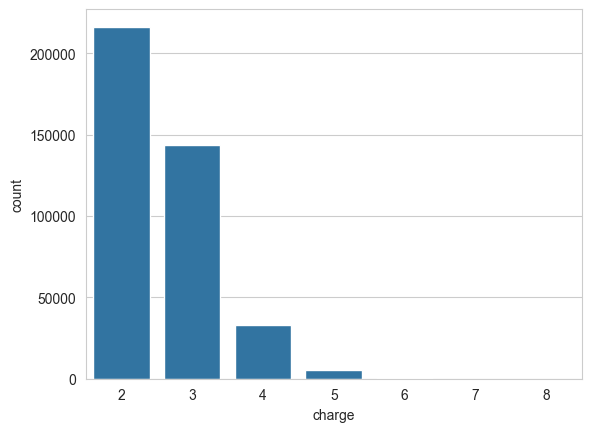

In [26]:
sns.countplot(data=spectrum_df, x="charge")
plt.show()

#### Peptide length

Idem for the length of the peptide sequence. It usually makes sense to filter 
the train dataset for peptides within a certain length range.

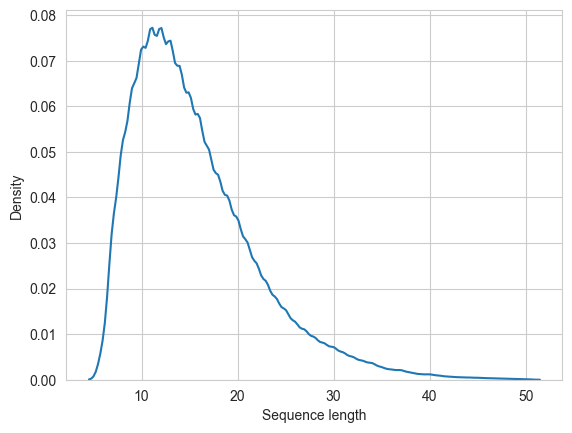

In [27]:
sns.kdeplot(spectrum_df["sequence"].str.len())
plt.xlabel("Sequence length")
plt.show()

In [28]:
spectrum_df["sequence"].str.len().describe()

count    398373.000000
mean         15.541467
std           6.506968
min           6.000000
25%          11.000000
50%          14.000000
75%          19.000000
max          50.000000
Name: sequence, dtype: float64

In [29]:
(spectrum_df["sequence"].str.len() > 35).value_counts(normalize=True)

sequence
False    0.98759
True     0.01241
Name: proportion, dtype: float64

For this dataset, the minimum peptide length is 6, while the maximum is 50.
Nevertheless, only 1.2% have a peptide lenght higher than 35.

##### Peptide modifications

Likewise, peptide modifications can influence peptide fragmentation. How many of the spectra in our library come from modified peptides?

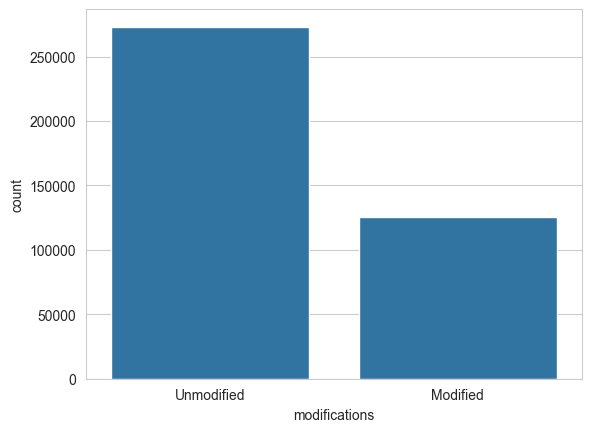

In [30]:
modification_state = (spectrum_df["modifications"] == "0").map({True: "Unmodified", False: "Modified"})
sns.countplot(x=modification_state)
plt.show()

#### Collision energy

Similarly, the fragmentation collision energy (CE) might influence the observed
fragmentation patterns.

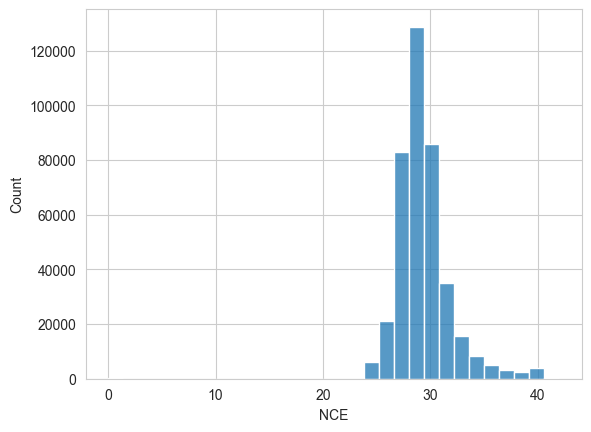

In [31]:
sns.histplot(spectrum_df["nce"], bins=30)
plt.xlabel("NCE")
plt.show()

Note the range of the x-axis, which was automatically chosen by the plotting library. It seems to start at 0, which indicates that some values are very low...

In [32]:
(spectrum_df["nce"] == 0.0).value_counts()

nce
False    398103
True        270
Name: count, dtype: int64

Indeed, it seems that some peptide spectra have CE `0`, which most likely means that the
true CE setting is not known. We can either opt to not use CE as a feature for training,
or to remove these spectra from the dataset. Including these values would introduce
unwanted noise in the training data.

#### Duplicate entries?

An important aspect to compiling training data for machine learning is whether or not entries are duplicated. With spectral libraries, matters are complicated by multiple levels of "uniqueness":

- Peptide level: Unique sequence
- Peptidoform level: Unique sequence & modifications
- Precursor level: Unique sequence & modifications & charge

More parameters can be included for "uniqueness", such as instrument and acquisition properties: CE, fragmentation method (beam-type CID ("HCD"), trap-type CID, ETD, EAD...), acquisition method (Orbitrap, ion trap, TOF...). In this tutorial, we are using only HCD Orbitrap data, which makes things a bit simpler. Nevertheless, this will impact the application domain of the final models.

In [33]:
counts = pd.DataFrame({
    "Level": [
        "Full library",
        "Precursor",
        "Peptidoform",
        "Peptide",
    ],
    "Count": [
        spectrum_df.shape[0],
        spectrum_df[["sequence", "modifications", "charge"]].drop_duplicates().shape[0],
        spectrum_df[["sequence", "modifications"]].drop_duplicates().shape[0],
        spectrum_df["sequence"].unique().shape[0],
    ],
})

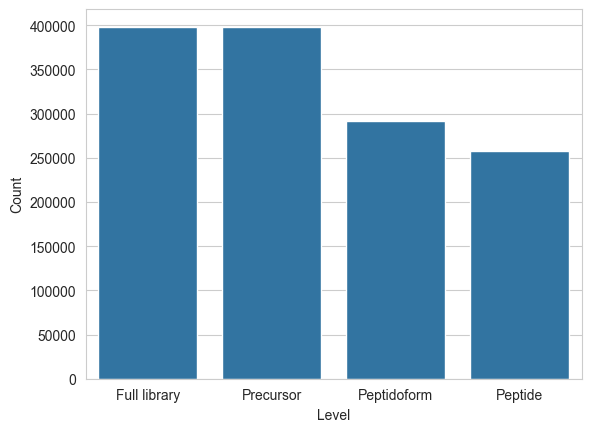

In [34]:
sns.barplot(data=counts, x="Level", y="Count")
plt.show()

In [35]:
counts

,Level,Count
0,Full library,398373
1,Precursor,398373
2,Peptidoform,292061
3,Peptide,257202


Seems like this library was already filtered for uniqueness on the precursor level.

### 5.2 Selecting data

For selecting training data, we will apply some additional filters:

- While plain amino acid sequences are straightforward to encode, peptide modifications complicate matters. For simplicity's sake, we will therefore not open the "can of modifications" in this tutorial.
- As we might want to use CE as a feature, we can remove the small amount of entries that are missing the a CE value
- To make the training task a bit less complex, we can limit peptide length to 35. Although the maximum peptide length in this library is 50, only 4944 spectra have a peptide length of over 35.

In [36]:
spectrum_df = spectrum_df[
    (modification_state == "Unmodified") &
    (spectrum_df["sequence"].str.len() <= 35) &
    (spectrum_df["nce"] != 0)
]

Let's see how many spectra we retained:

In [37]:
spectrum_df.shape[0]

270440

### 5.3 Train / validation / test split

Now that we have our data, we can filter it to a final set for training and validation
and a final set for testing. A small reminder of what these terms mean:

- Training data: For training the model
- Validation data: For validating the model while optimizing hyperparameters
- Testing data: For final testing of model that was trained with the best
hyperparameters (according to the validation data), right before deployment

The testing data cannot be used until a final model is trained, and serves as a last
test before deployment. It should not be used before a final model is selected. 

In [38]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

train_val_peptides, test_peptides = train_test_split(spectrum_df["sequence"].unique(), train_size=0.9)
train_val_spectra = spectrum_df[spectrum_df["sequence"].isin(train_val_peptides)]
test_spectra = spectrum_df[spectrum_df["sequence"].isin(test_peptides)]

Why do we not apply `train_test_split()` directly on `spectrum_df`, but instead on `spectrum_df["sequence"].unique()`?

### 5.4 Saving the parsed library for the next tutorial parts

We will be saving the parsed spectral library to Arrow Feather files, a fast and
efficient binary format that can easily be read and written from Pandas.

In [39]:
train_val_spectra.reset_index().to_feather("fragmentation-nist-humanhcd20160503-parsed-trainval.feather")
test_spectra.reset_index().to_feather("fragmentation-nist-humanhcd20160503-parsed-test.feather")

Continue with part 2 of this tutorial:<br>
👉[Traditional ML: Gradient boosting][part2]

[part2]: https://www.proteomicsml.org/tutorials/fragmentation/nist-2-traditional-ml-gradient-boosting.html